In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000], generator = torch.Generator().manual_seed(515))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=24)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=24)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=24)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class LightningNet(pl.LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        self.save_hyperparameters()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        val_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=10)
        self.log("val_loss", val_loss)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        val_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=10)
        self.log("test_loss", val_loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.model.parameters(), self.lr, momentum=0.9)
        return [optimizer]
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = torch.argmax(self.model(x), dim=1)
        return pred

In [6]:
basicnn = LightningNet(Net(), 0.01)

# train model
trainer = pl.Trainer(accelerator="gpu", max_epochs = 5, default_root_dir="./basicnn/checkpoint", callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)])
trainer.fit(model=basicnn, train_dataloaders = trainloader, val_dataloaders = valloader)

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to ena

Sanity Checking: 0it [00:00, ?it/s]

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:536: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:536: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Epoch 0:   0%|          | 0/3126 [00:00<?, ?it/s]                          

[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 4: 100%|██████████| 3126/3126 [01:41<00:00, 30.81it/s, loss=1.44, v_num=27] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3126/3126 [01:42<00:00, 30.61it/s, loss=1.44, v_num=27]


In [7]:
trainer.test(basicnn, testloader)

Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Testing DataLoader 0: 100%|██████████| 625/625 [00:09<00:00, 64.02it/s]

/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:536: PossibleUserWarning: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/nicholas/anaconda3/envs/cifar10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:536: PossibleUserWarning: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Testing DataLoader 0: 100%|██████████| 625/625 [00:10<00:00, 58.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5180000066757202
        test_loss           1.3463249206542969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3463249206542969, 'test_acc': 0.5180000066757202}]

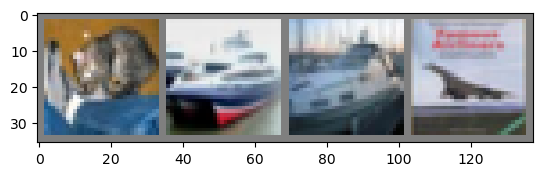

GroundTruth:    cat  ship  ship plane
Predicted:    cat truck   car plane


In [8]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = basicnn(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [9]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

def attribute_image_features(algorithm, input, **kwargs):
    basicnn.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

saliency = Saliency(basicnn)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(basicnn)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Original Image
Predicted: plane  Probability: 0.793835461139679


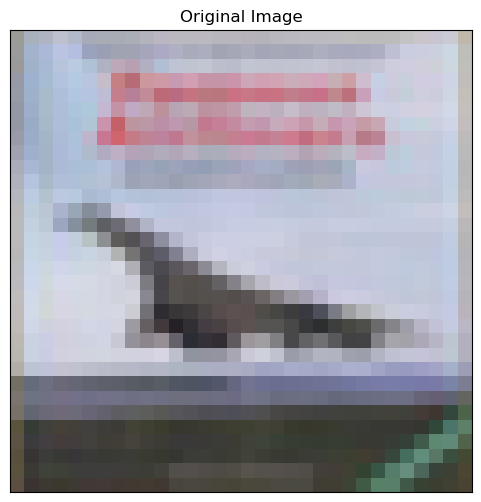

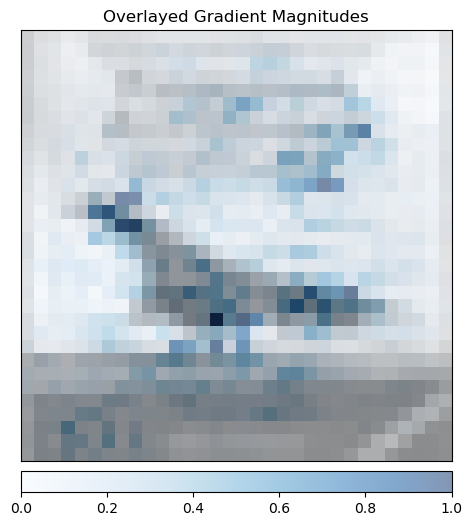

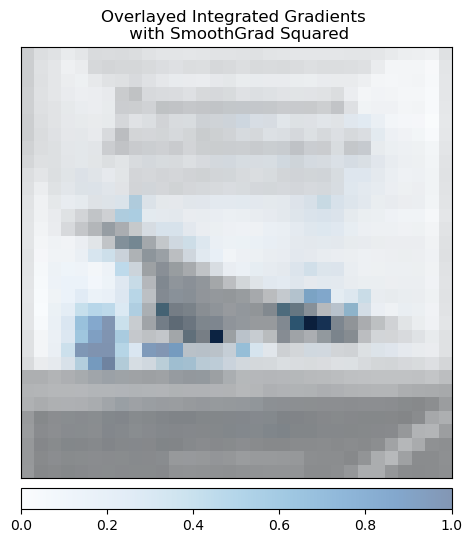

In [11]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")